# Import the Data and Split Into Test and Training Sets

In [166]:
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import random

%matplotlib inline

n_mult=1
noise_level=.5

directory= './Data/Local Sensitivity/'
# directory = './Data/Global Sensitivity'
runs = []
for filename in os.listdir(directory):
    if filename.startswith('gen'):
        run = int(filename.split('_')[2].split('.')[0])
        runs.append(run)
       
count=0

# set up the Pandas Dataframes
volts=pd.DataFrame(columns=range(255),dtype=np.float64)
times=pd.DataFrame(columns=range(255),dtype=np.float64)
vals=pd.DataFrame(columns=range(41),dtype=np.float64)
temp1=[]
temp2=[]
temp3=[]
names=[]
count=0
# Iterate through the files
for run in sorted(runs):
    count=count+1
    if True:
        filename = '/gen_data_' + str(run) + '.csv'
        data = pd.read_csv(directory + filename, sep=',')
        temp1=[]
        temp2=[]
        temp3=[]
        # parse the data
        for column in data.columns:
            if column.find('olts')>0:
                temp1=np.concatenate((temp1,data[column].tolist()))
            if column.find('ime')>0:
                temp3=np.concatenate((temp3,data[column].tolist()))
            if column.find('olts') + column.find('urrent') + column.find('ime') < -2:
                if data[column][0]!=0:
                    temp2.append(data[column][0])
        volts.loc[run,:]=temp1
        vals.loc[run,:]=temp2
        times.loc[run,:]=temp3


for column in data.columns:
    if column.find('olts') + column.find('urrent') + column.find('ime') < -2:
        if data[column][0]!=0:
            names.append(column) 

# Split the data into 'test' and 'training' sets
train = sorted(random.sample(range(volts.shape[0]), int(volts.shape[0]*(3.0/4))))
test = [x for x in range(volts.shape[0]) if x not in train]
P=vals
P_mean = P.mean()
P_std = P.std()

# Normalize the data
P = (P - P.mean())/P.std()

times_train=times.iloc[train,:]
Z_train = volts.iloc[train,:]
P_train = P.iloc[train,:]

times_test = times.iloc[test,:]
Z_test = volts.iloc[test,:]
P_test = P.iloc[test,:]

X_train = pd.DataFrame()
Y_train = pd.DataFrame()

X_train_noise = pd.DataFrame()
X_test_noise = pd.DataFrame()

X_test = pd.DataFrame()
Y_test = pd.DataFrame()

# Add noise and possibly duplicate
for _ in range(n_mult):
                      
    X_test_noise = pd.concat((X_test, Z_test + np.random.randn(Z_test.shape[0],Z_test.shape[1])*noise_level))
    X_train_noise = pd.concat((X_train, Z_train + np.random.randn(Z_train.shape[0],Z_train.shape[1])*noise_level))
    
    Y_train = pd.concat((Y_train, P_train))
    X_train = pd.concat((X_train, Z_train))
    
    X_test = pd.concat((X_test, Z_test))  
    Y_test = pd.concat((Y_test, P_test))

times_train=np.array(times_train)    
X_train_noise = np.array(X_train_noise)
X_train = np.array(X_train)
Y_train = np.array(Y_train)


times_test=np.array(times_test)
X_test_noise = np.array(X_test_noise)
X_test = np.array(X_test)
Y_test = np.array(Y_test)


YY_train = Y_train
XX_train = X_train
print 'done'

X_full = np.array(volts)
Y_full = np.array(vals)
print count

done
406


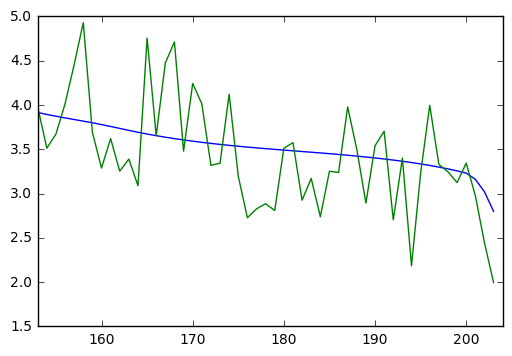

In [167]:
y_1=[]
for i in range(153,204):
    y_1.append(i)
for i in range(1):
    plt.plot(y_1,X_train[i][153:204])
    plt.plot(y_1,X_train_noise[i][153:204])

plt.xlim(153,204)
plt.show()

In [168]:
# Running different Regression methods
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model

import time
print("extra trees")
start_time = time.time()
etr = ExtraTreesRegressor(n_estimators=200, n_jobs=-1,max_depth=22)
etr.fit(X_train,Y_train)
print("--- %s seconds ---" % (time.time() - start_time))
print('Test:', etr.score(X_test,Y_test), 'Train:', etr.score(X_train,Y_train))
start_time = time.time()

print("KNN")
start_time = time.time()
knn = KNeighborsRegressor(n_neighbors=40,weights = 'distance')
knn.fit(X_train,Y_train)
print("--- %s seconds ---" % (time.time() - start_time))
print('Test:', knn.score(X_test,Y_test), 'Train:', knn.score(X_train,Y_train))

print("linear")
start_time = time.time()
lin = linear_model.LinearRegression()
lin.fit(X_train,Y_train)
print("--- %s seconds ---" % (time.time() - start_time))
print('Test:', lin.score(X_test,Y_test), 'Train:', lin.score(X_train,Y_train))


extra trees
--- 1.10400009155 seconds ---
('Test:', -0.0029919371409218242, 'Train:', 0.4044180615999291)
KNN
--- 0.0019998550415 seconds ---
('Test:', -0.016571808448892063, 'Train:', 0.39790313058437182)
linear
--- 0.0220000743866 seconds ---
('Test:', -1.3971957516977471e+20, 'Train:', 0.40310520999957322)


# Visualizing the Data
## How do the different types of algorithms compare?

56


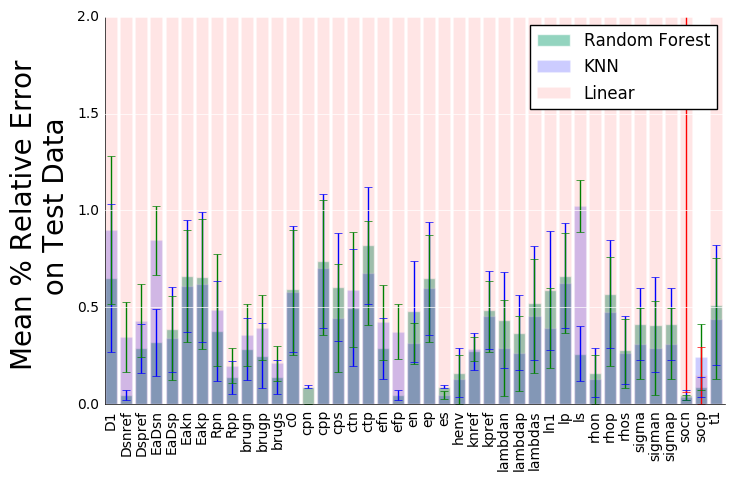

In [169]:
### plot all 3 on the same chart
import prettyplotlib as ppl
print len(data.columns)
a = []
aa = []
aaa = []

predicted1 = etr.predict(X_test)
predicted2 = knn.predict(X_test)
predicted3 = lin.predict(X_test)
for j in range(Y_test.shape[1]):
    re = []
    for i in range(len(Y_test)):
        predicted = predicted1[i][j]*P_std[j] + P_mean[j]
        true = Y_test[i][j]*P_std[j] + P_mean[j]
        re.append(np.abs((predicted - true)/true))
    a.append(re)
    re=[]
    for i in range(len(Y_test)):
        predicted = predicted2[i][j]*P_std[j] + P_mean[j]
        true = Y_test[i][j]*P_std[j] + P_mean[j]
        re.append(np.abs((predicted - true)/true))
    aa.append(re)
    re=[]
    for i in range(len(Y_test)):
        predicted = predicted3[i][j]*P_std[j] + P_mean[j]
        true = Y_test[i][j]*P_std[j] + P_mean[j]
        re.append(np.abs((predicted - true)/true))
    aaa.append(re)
    
results1 = np.array(a)
means1 = np.ndarray(shape=(P.shape[1],))
stds1 = np.ndarray(shape=(P.shape[1],))
results2 = np.array(aa)
means2 = np.ndarray(shape=(P.shape[1],))
stds2 = np.ndarray(shape=(P.shape[1],))
results3 = np.array(aaa)
means3 = np.ndarray(shape=(P.shape[1],))
stds3 = np.ndarray(shape=(P.shape[1],))


for p in range(results1.shape[0]):
    mean1 = results1[p].mean()
    std1 = results1[p].std()
    mean2 = results2[p].mean()
    std2 = results2[p].std()
    mean3 = results3[p].mean()
    std3 = results3[p].std()
    
    means1[p] = mean1
    stds1[p] = std1/np.sqrt(results1.shape[1])
    means2[p] = mean2
    stds2[p] = std2/np.sqrt(results2.shape[1])
    means3[p] = mean3
    stds3[p] = std3/np.sqrt(results3.shape[1])
fig = plt.figure(1, figsize=(8,5))
ppl.bar(range(results1.shape[0]), means1*100, yerr=stds1*100,
        xticklabels=names, grid='y', alpha=0.7,label='Random Forest') # etr
ppl.bar(range(results2.shape[0]), means2*100, yerr=stds2*100, 
        grid='y', color='b', alpha=0.2,label='KNN') # knn
ppl.bar(range(results3.shape[0]), means3*100, yerr=stds3*100, 
        grid='y', color='r', alpha=0.1, label='Linear') # lin
plt.ylim(0,2)
plt.legend()
plt.ylabel('Mean % Relative Error \n on Test Data', fontsize=20)
plt.xticks(rotation='vertical', ha='center')
plt.xlim(0,41)
plt.show()

# What about giving each variable its own Random Forest?

In [170]:
from sklearn.ensemble import ExtraTreesRegressor
aaaa = []
for j in range(P.shape[1]):
    Y_temp = np.zeros((len(YY_train),))
    Y_temp2 = np.zeros((len(Y_test),))

    for i in range(len(Y_test)):
        Y_temp2[i]=Y_test[i][j]
    start_time = time.time()
    etr7 = ExtraTreesRegressor(n_estimators=200, n_jobs=-1,max_depth=22)
    etr7.fit(X_train,Y_temp)
    print names[j], "Test score:", etr7.score(X_test,Y_temp2)
    predicted3 = etr7.predict(X_test)
    re = []
    for i in range(len(Y_test)):
        predicted = predicted3[i]*P_std[j] + P_mean[j]
        true = Y_test[i][j]*P_std[j] + P_mean[j]
        re.append(np.abs((predicted - true)/true))
    aaaa.append(re)

D1 Test score: -0.000784929356353
Dsnref Test score: -0.000859440089961
Dspref Test score: -0.013191413478
EaDsn Test score: -0.0199283584356
EaDsp Test score: -0.015180043337
Eakn Test score: -0.00903085977714
Eakp Test score: -0.000585593335709
Rpn Test score: -1.56940287508e-05
Rpp Test score: -0.00136955807734
brugn Test score: -0.00533191991601
brugp Test score: -0.00176289054628
brugs Test score: -0.00136955807741
c0 Test score: -0.00161006649303
cpn Test score: -6.67537634723e+30
cpp Test score: -0.00593269647697
cps Test score: -0.0113598655793
ctn Test score: -0.000515664053969
ctp Test score: -0.0100004858076
efn Test score: -0.0113412599204
efp Test score: -0.00820149540687
en Test score: -0.00773496080939
ep Test score: -0.0232909904668
es Test score: -6.00783871242e+31
henv Test score: -0.00334541935353
knref Test score: -6.00783871253e+31
kpref Test score: -0.00555103194076
lambdan Test score: -0.0105013784453
lambdap Test score: -0.00384169605741
lambdas Test score: -1.9

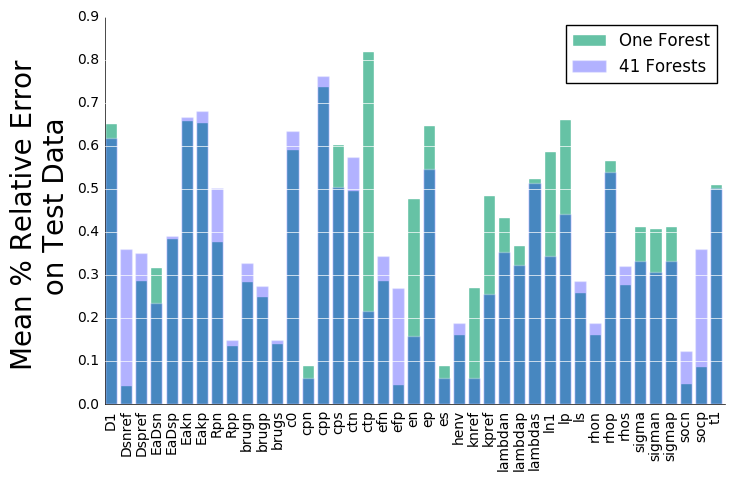

In [171]:
results=np.array(a)
results2 = np.array(aaaa)
means = np.ndarray(shape=(P.shape[1],))
stds = np.ndarray(shape=(P.shape[1],))
means2 = np.ndarray(shape=(P.shape[1],))
stds2 = np.ndarray(shape=(P.shape[1],))

for p in range(results.shape[0]):
    mean = results[p].mean()
    std = results[p].std()
    
    means[p] = mean
    stds[p] = std/np.sqrt(results.shape[1])

for p in range(results2.shape[0]):  
    mean2 = results2[p].mean()
    std2 = results2[p].std()
    
    means2[p] = mean2
    stds2[p] = std2/np.sqrt(results2.shape[1])
import prettyplotlib as ppl

fig = plt.figure(1, figsize=(8,5))
ppl.bar(range(results.shape[0]), means*100,
        xticklabels=names, grid='y', label='One Forest')
ppl.bar(range(results2.shape[0]), means2*100,
        xticklabels=names, grid='y', color='b', alpha=0.3, label='41 Forests')
plt.ylabel('Mean % Relative Error \n on Test Data', fontsize=20)
plt.xticks(rotation='vertical', ha='center')
plt.legend()
plt.xlim(0,P.shape[1])
plt.show()


# Can adding noise help?

In [172]:
from sklearn.ensemble import ExtraTreesRegressor
aaaaa = []
for j in range(P.shape[1]):
    Y_temp = np.zeros((len(YY_train),))
#     Y_temp2 = np.zeros((len(Y_test),))
    for i in range(len(Y_test)):
        Y_temp2[i]=Y_test[i][j]
    start_time = time.time()
    etr8 = ExtraTreesRegressor(n_estimators=200, n_jobs=-1,max_depth=22)
    etr8.fit(X_train_noise,Y_temp)
    print names[j], "Test score:", etr8.score(X_test_noise,Y_temp2)
    predicted3 = etr8.predict(X_test_noise)
    re = []
    for i in range(len(Y_test)):
        predicted = predicted3[i]*P_std[j] + P_mean[j]
        true = Y_test[i][j]*P_std[j] + P_mean[j]
        re.append(np.abs((predicted - true)/true))
    aaaaa.append(re)

D1 Test score: -0.000784929356353
Dsnref Test score: -0.000859440089961
Dspref Test score: -0.013191413478
EaDsn Test score: -0.0199283584356
EaDsp Test score: -0.015180043337
Eakn Test score: -0.00903085977714
Eakp Test score: -0.000585593335709
Rpn Test score: -1.56940287508e-05
Rpp Test score: -0.00136955807734
brugn Test score: -0.00533191991601
brugp Test score: -0.00176289054628
brugs Test score: -0.00136955807741
c0 Test score: -0.00161006649303
cpn Test score: -6.67537634723e+30
cpp Test score: -0.00593269647697
cps Test score: -0.0113598655793
ctn Test score: -0.000515664053969
ctp Test score: -0.0100004858076
efn Test score: -0.0113412599204
efp Test score: -0.00820149540687
en Test score: -0.00773496080939
ep Test score: -0.0232909904668
es Test score: -6.00783871242e+31
henv Test score: -0.00334541935353
knref Test score: -6.00783871253e+31
kpref Test score: -0.00555103194076
lambdan Test score: -0.0105013784453
lambdap Test score: -0.00384169605741
lambdas Test score: -1.9

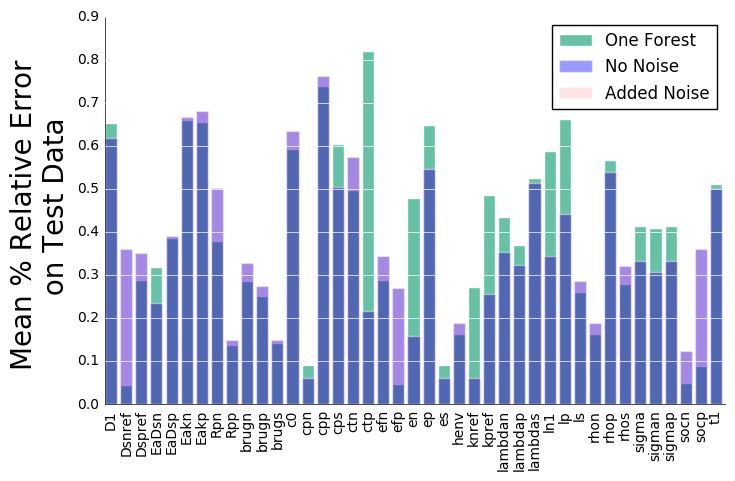

In [173]:
results1 = np.array(a)
results2 = np.array(aaaa)
results3 = np.array(aaaaa)
means = np.ndarray(shape=(P.shape[1],))
stds = np.ndarray(shape=(P.shape[1],))
means2 = np.ndarray(shape=(P.shape[1],))
stds2 = np.ndarray(shape=(P.shape[1],))
means3 = np.ndarray(shape=(P.shape[1],))
stds3 = np.ndarray(shape=(P.shape[1],))

for p in range(results1.shape[0]):
    mean = results1[p].mean()
    std = results1[p].std()
    
    means[p] = mean
    stds[p] = std/np.sqrt(results1.shape[1])

for p in range(results2.shape[0]):  
    mean2 = results2[p].mean()
    std2 = results2[p].std()
    
    means2[p] = mean2
    stds2[p] = std2/np.sqrt(results2.shape[1])

for p in range(results3.shape[0]):  
    mean3 = results3[p].mean()
    std3 = results3[p].std()
    
    means3[p] = mean3
    stds3[p] = std3/np.sqrt(results3.shape[1])
import prettyplotlib as ppl

fig = plt.figure(1, figsize=(8,5))
ppl.bar(range(results1.shape[0]), means1*100,
        xticklabels=names, grid='y',label='One Forest')
ppl.bar(range(results2.shape[0]), means2*100,
        xticklabels=names, grid='y', color='b', alpha=0.4,label='No Noise')
ppl.bar(range(results3.shape[0]), means3*100,
        xticklabels=names, grid='y', color='r', alpha=0.1, label='Added Noise')
plt.ylabel('Mean % Relative Error \n on Test Data', fontsize=20)
plt.xticks(rotation='vertical', ha='center')
plt.legend()
plt.xlim(0,P.shape[1])
plt.show()